<a href="https://colab.research.google.com/github/KlausKUEKOU/fleshdashkk/blob/main/ANA_forum_Whatsapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***De quoi parle t-on dans ce forum Whatsapp?***

### *Importation des librairies  utile*

In [2]:
!pip -q install pandas numpy matplotlib wordcloud regex unidecode prince scikit-learn transformers sentencepiece torch emoji

import re
import emoji
import numpy as np
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
from unidecode import unidecode
from wordcloud import WordCloud
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 31.0 MB/s eta 0:00:00


### *Charger le fichier .txt et le lire sous forme de dataframe*

In [3]:
uploaded = files.upload()
txt_name = list(uploaded.keys())[0]

with open(txt_name, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

Saving Discussion WhatsApp avec Formation initiale ISSEACEMAC.txt to Discussion WhatsApp avec Formation initiale ISSEACEMAC.txt


In [4]:
#Date, Heure, Auteur, Message
pattern = re.compile(r"^(\d{2}/\d{2}/\d{4}),\s(\d{2}:\d{2})\s-\s(.*?):\s(.*)$")

rows = []
current = None

# Lecture et Parsing
for line in lines:
    line = line.strip()
    if not line: continue

    m = pattern.match(line)
    if m:
        if current: rows.append(current)
        date_str, time_str, author, msg = m.groups()
        current = {
            "Date": date_str,
            "Heure": time_str,
            "Auteur": author.strip(),
            "Message": msg.strip()
        }
    else:
        # Gestion des messages multi-lignes
        if current:
            current["Message"] += " " + line

if current: rows.append(current)
df = pd.DataFrame(rows)

### *Nettoyage du dataframe obtenu*

In [5]:
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Heure"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["Datetime"]).sort_values("Datetime").reset_index(drop=True)

# Suppression des msg de l'appli
syst_msg = [
    "a ajouté", "a quitté", "a changé", "Les messages et les appels sont chiffrés",
    "Messages et appels sont chiffrés", "a supprimé ce message", "Vous avez ajouté"
]
mask_sys = df["Message"].str.contains("|".join([re.escape(k) for k in syst_msg]), case=False, na=False)
df = df[~mask_sys].reset_index(drop=True)

print("Nombre de lignes :", len(df))
df = df[["Datetime","Message"]]
df.head()

Nombre de lignes : 2772


,Datetime,Message
0,2025-12-23 13:38:00,<Médias omis>
1,2025-12-23 13:38:00,<Médias omis>
2,2025-12-23 13:38:00,Propre
3,2025-12-23 13:39:00,Les écureuils 🐿😂
4,2025-12-23 13:41:00,C’est changé big… ce nom sonne trop gentil 😂


### *Analyse Descriptive*

In [6]:
df_desc = df.copy()
df_desc["Date_only"] = df_desc["Datetime"].dt.date
df_desc["Jour"] = df_desc["Datetime"].dt.day_name()
df_desc["Heure_num"] = df_desc["Datetime"].dt.hour
df_desc["Longueur"] = df_desc["Message"].str.len()

print("Nombre total de messages :", len(df_desc))
print("Période :", df_desc["Datetime"].min(), "→", df_desc["Datetime"].max())
print("Longueur moyenne :", round(df_desc["Longueur"].mean(), 2))

Nombre total de messages : 2772
Période : 2025-12-23 13:38:00 → 2026-01-21 06:00:00
Longueur moyenne : 41.38


<Figure size 1500x1000 with 0 Axes>

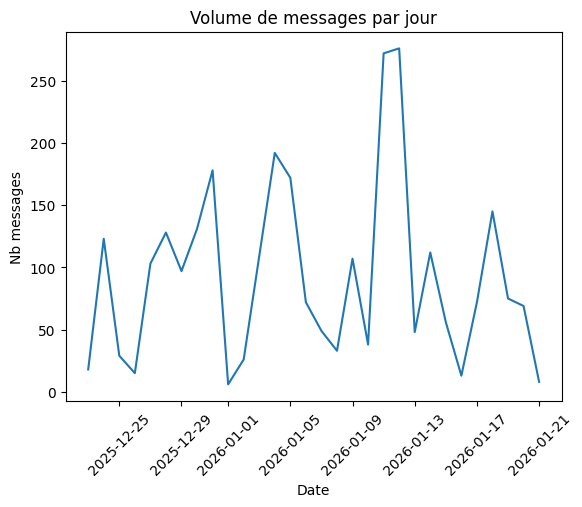

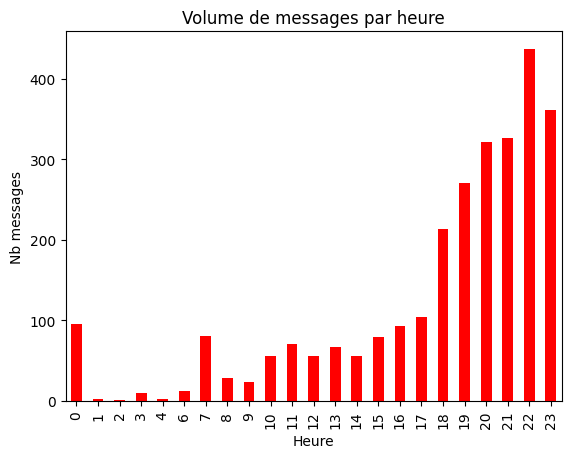

In [7]:
plt.figure(figsize=(15, 10))
msg_j = df_desc.groupby("Date_only").size()
msg_h = df_desc.groupby("Heure_num").size()

plt.figure()
msg_j.plot()
plt.title("Volume de messages par jour")
plt.xlabel("Date")
plt.ylabel("Nb messages")
plt.xticks(rotation=45)
plt.show()

plt.figure()
msg_h.plot(kind="bar", color = 'red')
plt.title("Volume de messages par heure")
plt.xlabel("Heure")
plt.ylabel("Nb messages")
plt.show()

Les heures d'intenses conversations au sein du groupe whatsapp sont les heures de la nuits entre 18h00 et 23h59. C'est un forum qui regroupe des étudiants, ces horaires sont donc clairement justifiées. On peut aussi noter que l'insentité des conversations diffères en fonction des jours. avec des jour ou l'on enregistre moins de 50 messages et d'autres avec plus de 250.

On va regarder la distribution de message média (note vocale, video et photos)

In [8]:
mask = df_desc["Message"].str.contains("<Médias omis>", na=False)

nb_text = len(df_desc) - mask.sum()
prop_media = (mask.sum() / len(df_desc)) * 100

print(f"Messages médias : {mask.sum()} ({prop_media:.2f}%)")
print(f"Messages texte à analyser : {nb_text}")

# les médias ne seront pas analysés
df_desc = df_desc[~mask].copy()


Messages médias : 723 (26.08%)
Messages texte à analyser : 2049


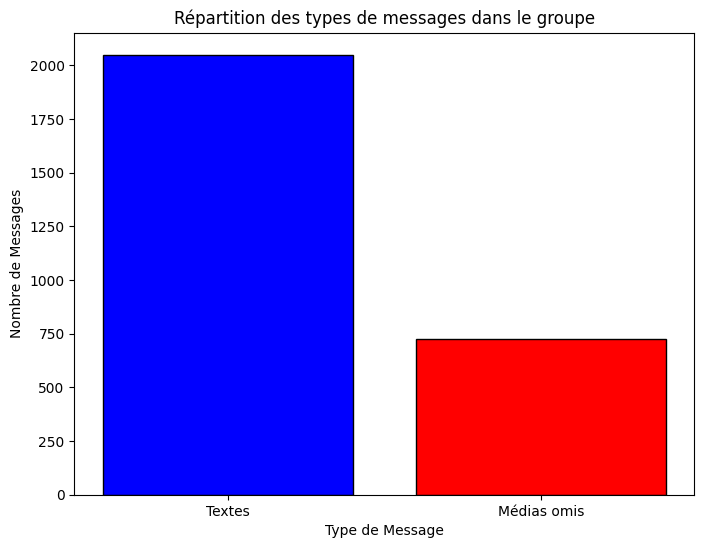

In [9]:
labels = ['Textes', 'Médias omis']
sizes = [nb_text, mask.sum()]
colors = ['blue', 'red']

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=colors, edgecolor='black')
plt.title("Répartition des types de messages dans le groupe")
plt.xlabel("Type de Message")
plt.ylabel("Nombre de Messages")
plt.show()

Un peu plus d'un quart des messages receuillies à travers ce forum sont des médias vidéeos photos et stickers. Ce qui pourrait traduire un bon niveau d'illustration d'idées dans les messages

### *Le forum est-il convivial?*

Il faut premièrement éliminer les tags et traduire les émojis en texte.

In [9]:
def nettoyage(text):
    text = re.sub(r'@[\w\d\s.-]+(?=\s|$)|@\w+', '', text)
    text = emoji.demojize(text, language='fr', delimiters=(" ", " "))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

msg_model = df_desc["Message"].astype(str).apply(nettoyage).tolist()

### *Occurences des mots*

In [10]:
stop_fr = set("""
au aux avec ce ces dans de des du elle en et eux il je la le les leur lui ma me même meme ils mes moi mon ne nos notre nous
on ou par pas pour qu que qui sa se ses son sur ta te tes toi ton tu un une vos votre vous c est sont sera message ete fait modifie faire
""".split())

def nettoyage_texte(s):
    s = s.lower()
    s = unidecode(s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_desc["Message1"] = df_desc["Message"].astype(str).apply(nettoyage_texte)
tokens = " ".join(df_desc["Message1"]).split()
tokens = [t for t in tokens if t not in stop_fr and len(t) > 2]

from collections import Counter
freq = Counter(tokens)
top = pd.DataFrame(freq.most_common(30), columns=["Mot","Occurences"])
top

,Mot,Occurences
0,real,106
1,match,102
2,mais,80
3,comme,79
4,plus,72
5,gars,57
6,benin,57
7,mbappe,55
8,can,50
9,quoi,49


### *Nuages de mots*

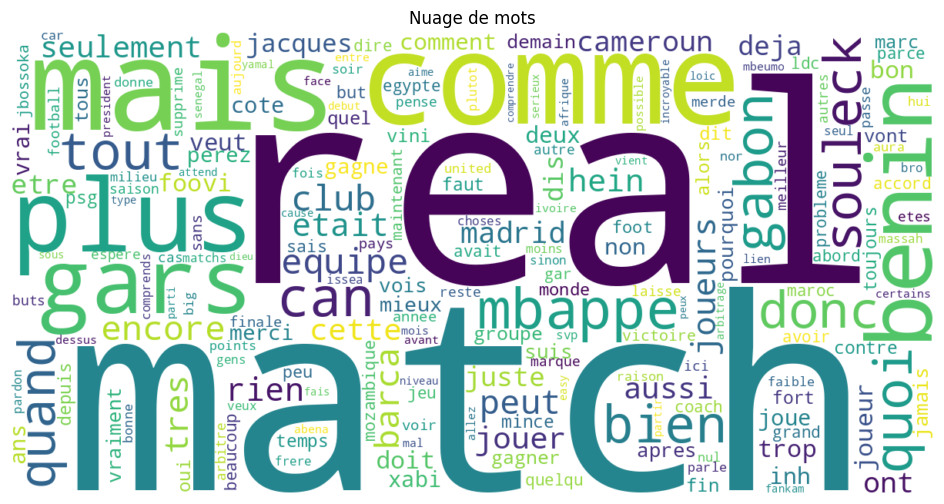

In [11]:
wc = WordCloud(width=1200, height=600, background_color="white").generate_from_frequencies(freq)

plt.figure(figsize=(14,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots")
plt.show()

- Au regard de ce nuage de mot on peut comprendre que les conversations
dans ce groupe portent majoritairement sur le football. les mots les plus utilisés sont match, real, Mbappé, can, benin, gabon.
- Le mot gars apparait aussi très utilisé dans les conversations, suggérant peut être que les débats sont monopolisés par des garçons.
- Les mots mais, plus, comme, quoi peuvent faire penser à des débats contradictoires, avec des comparaisons

Donc tout compte fait, les débats dans ce forum, durant cette période, ont majoritairement porté sur des questions de football. les discussions semblent avoir été des comparaisons et particulièrement animées par les garçons.

On va utiliser plusieurs modèle d'hugging face puis observer les résultats

In [18]:
models = {
    "BERT_Stars_Multi": "nlptown/bert-base-multilingual-uncased-sentiment",
    "Distil_FR_Fast": "cmarkea/distilcamembert-base-sentiment"
}

resultats = {"les_Msg": msg_model}

for name, model_lien in models.items():
    print(f"Analyse en cours avec : {name}...")
    pipe = pipeline("text-classification", model=model_lien, device=0)

    batch_preds = []
    for i in range(0, len(msg_model), 64):
        batch = msg_model[i:i+64]
        preds = pipe(batch, truncation=True, max_length=512)
        batch_preds.extend(preds)

    resultats[name] = [p['label'] for p in batch_preds]

df_resultats = pd.DataFrame(resultats)

Analyse en cours avec : BERT_Stars_Multi...


Device set to use cuda:0


Analyse en cours avec : Distil_FR_Fast...


Device set to use cuda:0


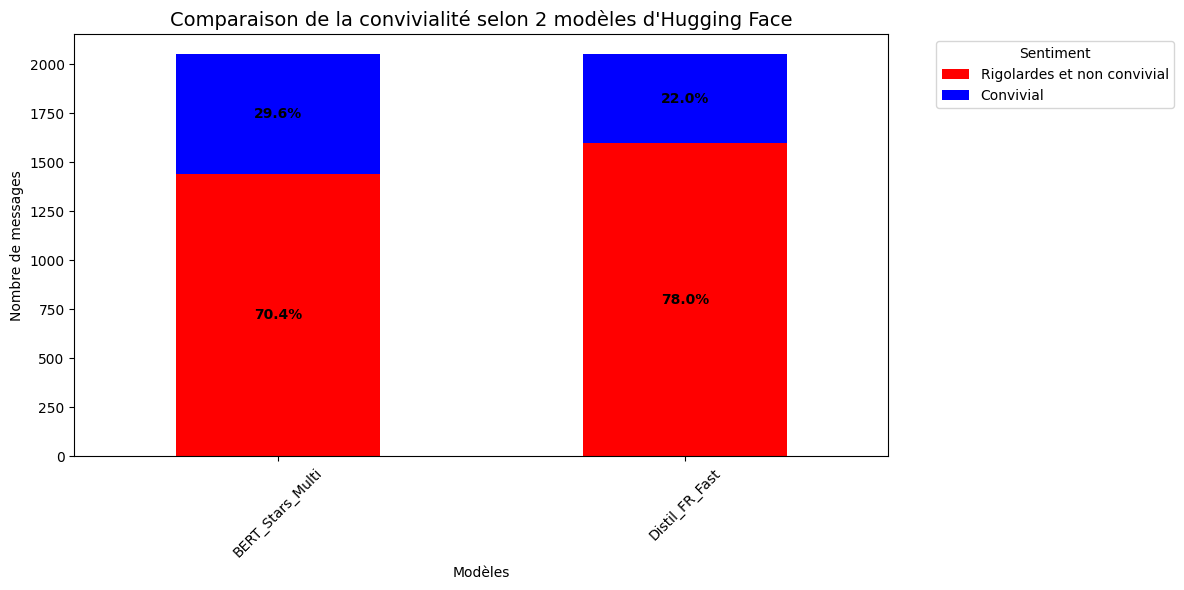

,les_Msg,BERT_Stars_Multi,Distil_FR_Fast
0,Propre,5 stars,4 stars
1,Les écureuils écureuil visage_riant_aux_larmes,1 star,3 stars
2,C’est changé big… ce nom sonne trop gentil vis...,1 star,1 star
3,Les guépards mains_en_prière_peau_foncée <Ce m...,1 star,1 star
4,Yohan Roche n’est pas un Araujo par hasard??? ...,1 star,1 star
5,symbole_bébé,5 stars,3 stars
6,https://chat.whatsapp.com/DZ75Qx0IXcR0jBgnQOGj...,1 star,1 star
7,stop stop stop stop Bonsoir S'il vous plaît qu...,1 star,1 star
8,Ce message a été supprimé.,1 star,1 star
9,En vrai visage_riant_aux_larmes visage_riant_a...,1 star,3 stars


In [20]:
def labeliser(label):
    label = str(label).lower()
    if label in ['5 stars', '4 stars']: return 'Convivial'
    return 'Non convivial'

df_plot = df_resultats.copy()
for col in models.keys():
    df_plot[col] = df_plot[col].apply(labeliser)

summary = df_plot[list(models.keys())].apply(pd.Series.value_counts).T

ax = summary.plot(kind='bar', stacked=True, color=['red', 'blue'], figsize=(12, 6))
totaux = summary.sum(axis=1)

for container in ax.containers:
    labels = [
        f'{(v.get_height() / totaux[i] * 100):.1f}%' if v.get_height() > 0 else ''
        for i, v in enumerate(container)
    ]
    ax.bar_label(container, labels=labels, label_type='center', color='black', fontsize=10, fontweight='bold')

plt.title("Comparaison de la convivialité selon 2 modèles d'Hugging Face", fontsize=14)
plt.ylabel("Nombre de messages")
plt.xlabel("Modèles")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



df_resultats.head(10)

La convivialité à été noté ici sur une échelle de 1 à 5; un message est dit convivial si le modèle lui attribue au moins 4 étoiles, au cas contraires on parlera de non convivial. Dans l'esprit non convivial veut pas dire des oppositions farouches à priori mais juste des messages visant à contredire, se moquer, ne pas apprécier etc...


---
Les modèles d'hugging face utilisés ici ont été basé sur des avis de clients par exemple Distill_Fr a été entrainé sur les retours sur amazones et allociné, Bert_stars_multi, lui est conçut pour analyser les sentiments des avis clients multilingues sur un produit.



*   le graphique des résultats montre que Distil_FR_Fast (22,0% de convivialité) est plus sévère que BERT_Stars_Multi (29,6% de convivialité)
*   La forte proportion de rouge (plus de 70%) ne signifie probablement pas que le forum est hostile, mais plutôt qu'il est animé par des débats très peu consensuels. C'est un groupe de discussion libre et ouverte donc pas vraiment de formule de politesse ce qui pénalise dans une certaine mesure la convivialité.


Le choix d'un modèle binaire dans ce cas s'explique par le fait que généralement dans des débats entre jeunes portant sur du football, il n'y a pas vraiment de consensus. Par ailleurs les discussions sur whatsapp n'ont généralement pas de contexte social bien défini, surtout pour ce type de forum.





